## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Esh: A Novel Activation Function for Improved Neural Network Performance</p>

Activation functions play a crucial role in the performance of neural networks by introducing non-linearity and allowing the network to learn complex relationships in the data. In this paper, we present Esh, a new activation function that is designed to improve the accuracy and efficiency of neural networks. 

Esh is defined as the hyperbolic tangent (tanh) of the sigmoid function applied to the input x and is based on the popular Mish function, but with a more gradual slope that helps it to better retain low-level features in the input data.
Esh is defined to be

$$
\text{Esh}(x) = x \tanh(\text{sigmoid}(x))
$$
where $\text{sigmoid}(x)=1/(1+e^{-x})$.

<br>

<br>
<center>
<img src='https://i.postimg.cc/HLcZVRHV/Novel-AFs-V1.png' width=650> 
<figcaption>Proposed AFs</figcaption>
<br>
<br>

To evaluate the effectiveness of Esh, we conducted experiments using a convolutional neural network (CNN) trained on the MNIST dataset, as well as the VGG16 and ResNet20 architectures on the CIFAR-10  dataset. We compared the performance of Esh to the ReLU, Swish, and Mish activation functions as baselines.
    
<br>
<center>
<img src='https://i.postimg.cc/NGHFRPbY/AFs-Known.png'
<figcaption>Proposed Esh vs Other AFs</figcaption>
<br>    

In [ ]:
!pip install -Uq wandb
!pip install -Uq tensorflow-addons 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Implementation</p>

In [ ]:
from keras.applications import VGG16
from keras.layers import Activation
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import tensorflow.keras as keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar100, cifar10
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.generic_utils import get_custom_objects
from keras.activations import swish, leaky_relu, relu, gelu, elu, softplus, softsign

import pandas as pd
import numpy as np
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', font_scale=1.6, rc={"figure.dpi":250, 'savefig.dpi':250})

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

import wandb
from wandb.keras import WandbCallback

In [ ]:
# Set random seeds
def set_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [ ]:
# Define the Esh activation function
def esh(x):
    return x * K.tanh(K.sigmoid(x))

def mish(x):
    return tfa.activations.mish(x)

get_custom_objects().update({'mish': Activation(mish)})
get_custom_objects().update({'esh': Activation(esh)})

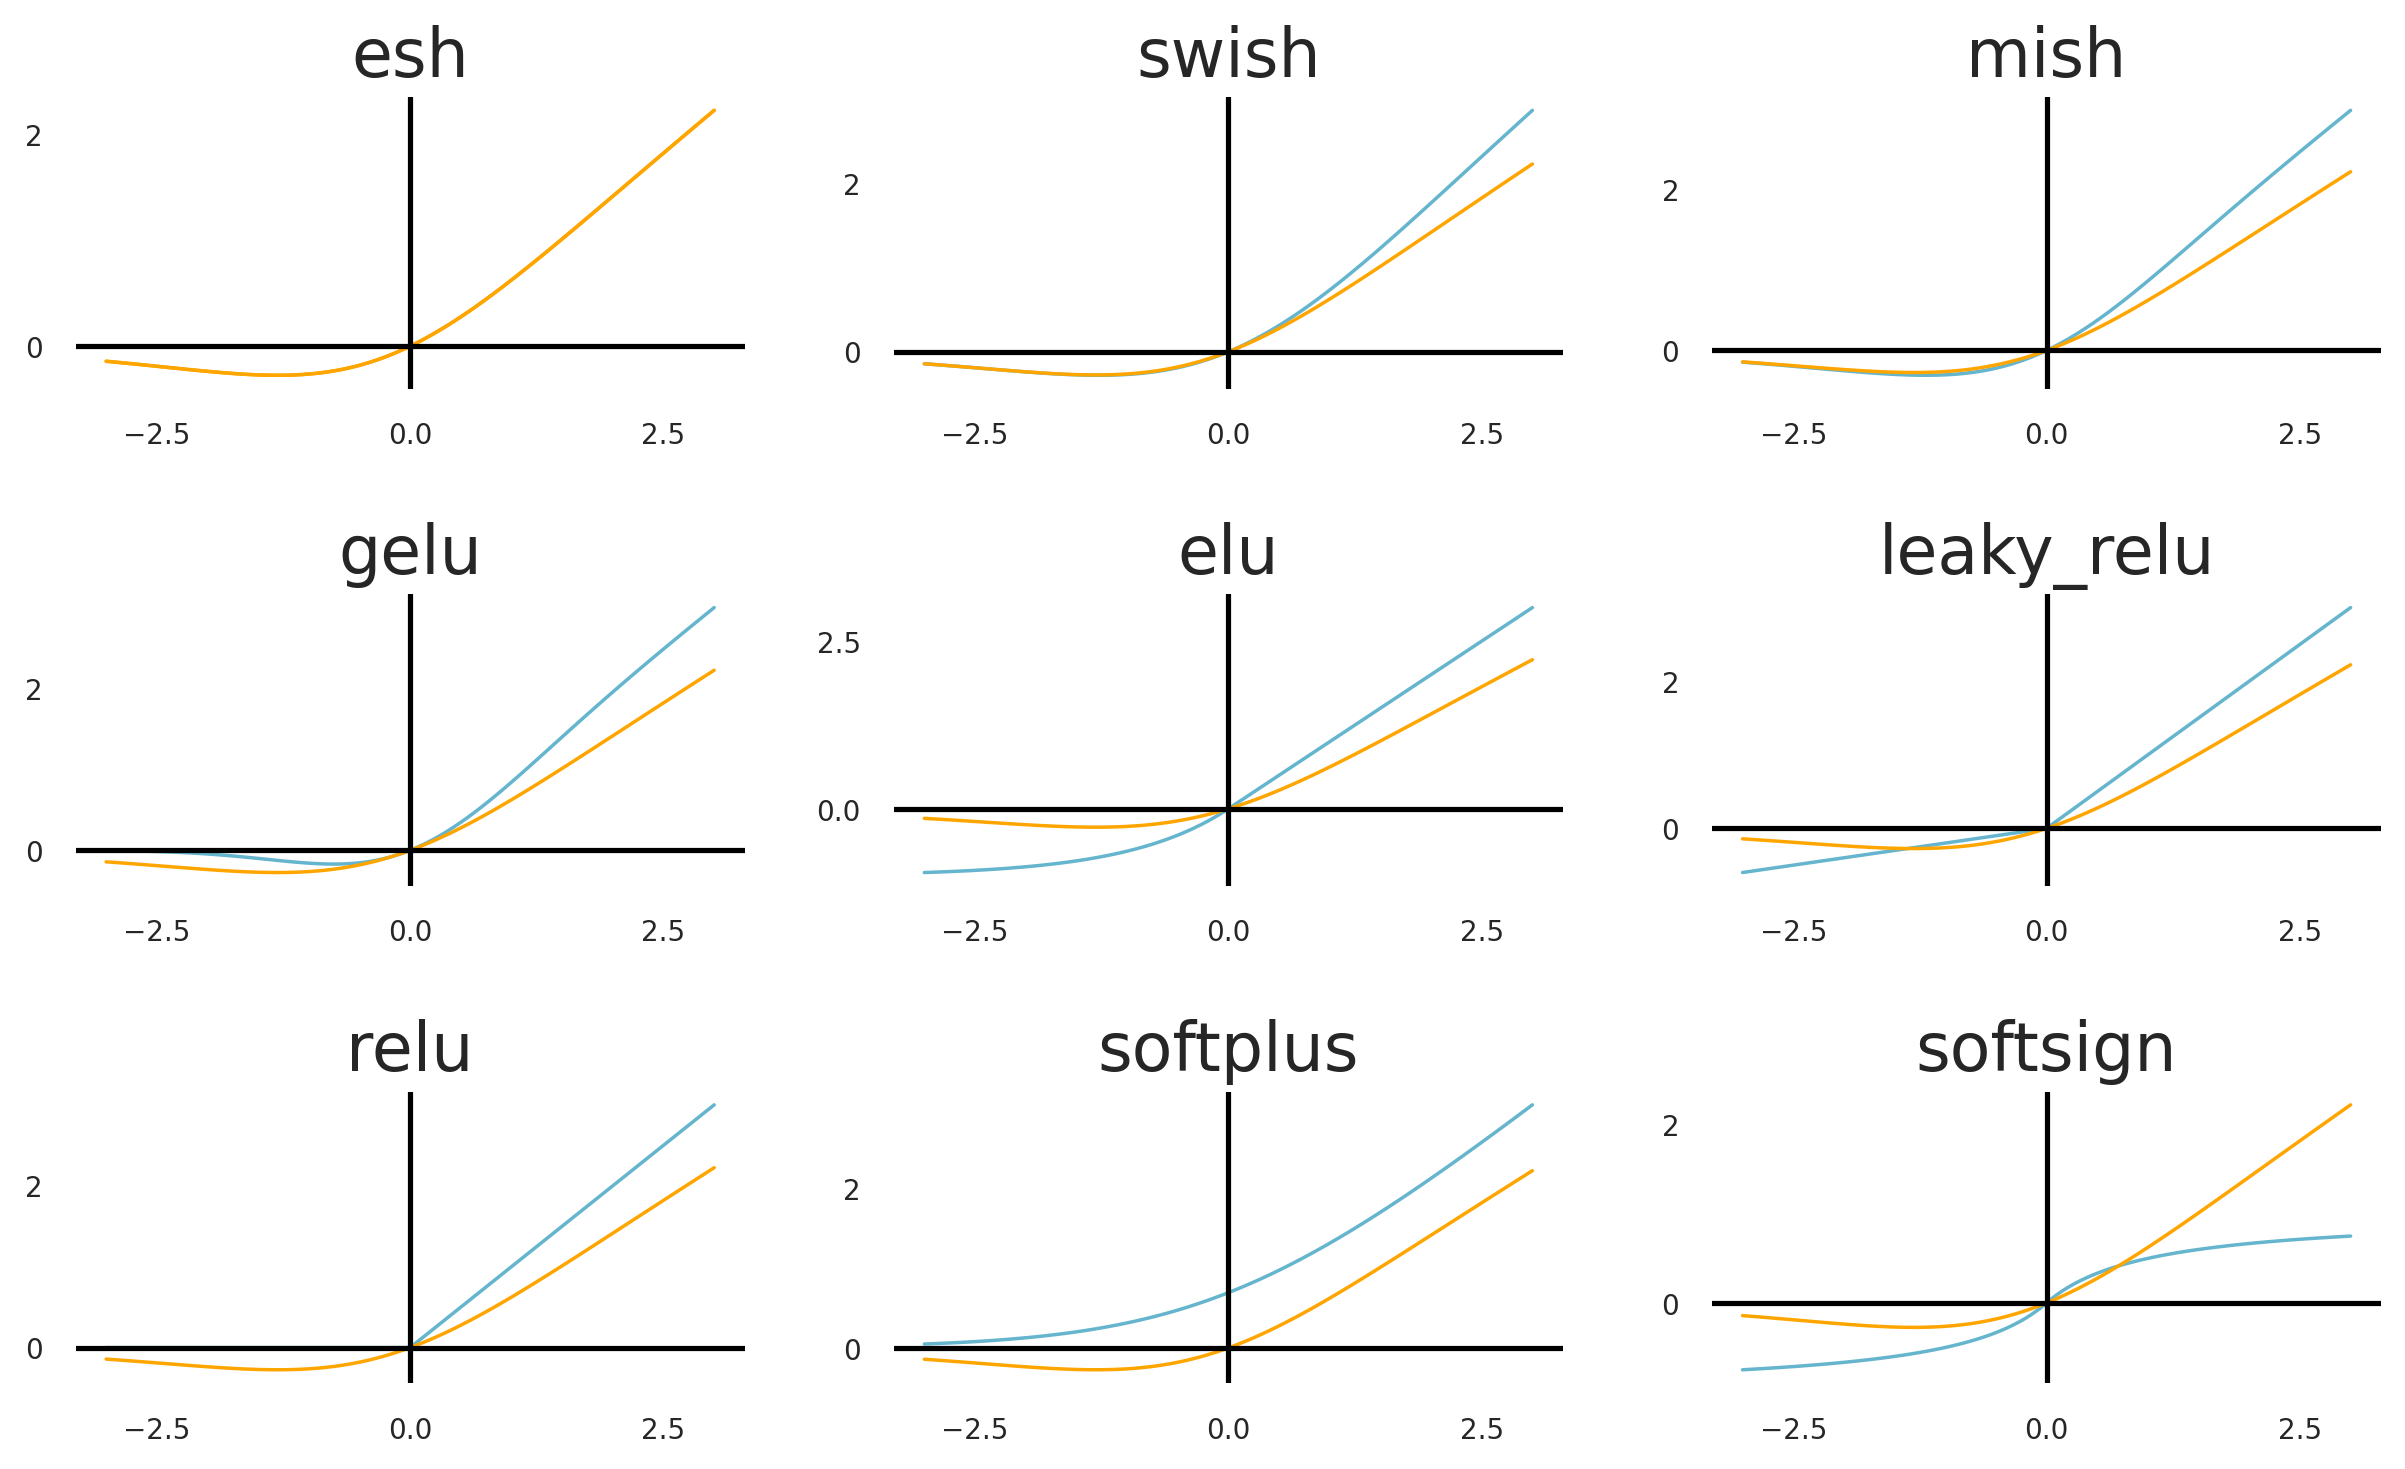

In [ ]:
#### Grid
xx = np.linspace(start=-3,stop=3,num=100)
afs = [esh, swish, mish, gelu, elu, leaky_relu, relu]

#### Plot activation functions
plt.figure(figsize=(10,8))
for i, act_fuct in enumerate(afs):
    c = 'c'
    if act_fuct.__name__ == 'esh':
        c = 'orange'
    plt.subplot(4,3,i+1)
    plt.plot(xx,act_fuct(xx), color=c, linewidth=1)
    plt.plot(xx,esh(xx), color='orange', linewidth=1)
    plt.axhline(color='black')
    plt.axvline(color='black')
    plt.title(act_fuct.__name__)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
sns.despine(bottom=True,left=True)
plt.show()

In [ ]:
#settings
img_shape = (32, 32, 3)
batch_size = 32
n_classes = 10
epochs = 200
version_string = 'v1_cifar10'

from keras.optimizers import SGD
optimizer = Adam()

loss = 'categorical_crossentropy'
metrics = ['accuracy']
verbose=1
early_stop_patience = epochs

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalise and reshape arrays
x_train, x_test = x_train.reshape((-1, 784))/255.0, x_test.reshape((-1, 784))/255.0

# Print shapes
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [ ]:
def build_mnist_model(act_func='esh', depth=15, dropout = 0.25, units = 50):  
    # Sequential model
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(784,)))
    
    # Hidden layers
    for i in range(depth-1):
        model.add(layers.Dense(units))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(act_func))
        model.add(layers.Dropout(rate=dropout))
    
    # Output layer
    model.add(layers.Dense(units=10, activation='softmax'))
       
    return model

In [ ]:
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, )

In [ ]:
def train(model, epochs=10, lr=1e-3, optimizer='sgd', log_freq=10):  
    
    tf.keras.backend.clear_session()
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=get_optimizer(lr, optimizer), 
                  metrics=["sparse_categorical_accuracy"])

    # callback setup
    wandb_callbacks = [WandbCallback(compute_flops=True, 
                                     log_freq = log_freq, 
                                     save_best_only=True,
                                     validation_data=(x_test, y_test))]
    
    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_test, y_test), 
              callbacks=wandb_callbacks)

In [ ]:
def sweep_train(config_defaults=None):

    with wandb.init(config=config_defaults):  

        wandb.config.architecture_name = "NN"
        wandb.config.dataset_name = "MNIST"

        # initialize model
        model = build_mnist_model(act_func=wandb.config.act 
                                  )

        train(model, 
              10,
              0.01,
              wandb.config.optimizer
             )

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
               'act': {
            'values': ['leaky_relu', 'relu', 'gelu', 'elu','softplus', 'softsign']
        }
    }
}

In [ ]:
%env "WANDB_NOTEBOOK_NAME" "NN_MNIST_WB"


wandb.login() #a96eb1d17152292d104d045304f8da02ab8fe0e1

sweep_id = wandb.sweep(sweep_config, project="NN_MNIST_WB_Final_v1")

wandb.agent(sweep_id, function=sweep_train)

env: "WANDB_NOTEBOOK_NAME"="NN_MNIST_WB"


wandb: Currently logged in as: rsuresh002 (pes_mtech_jun21_g3). Use `wandb login --relogin` to force relogin


Create sweep with ID: syxgr6gd
Sweep URL: https://wandb.ai/pes_mtech_jun21_g3/NN_MNIST_WB_Final_v1/sweeps/syxgr6gd


wandb: Agent Starting Run: ughontrm with config:
wandb: 	act: leaky_relu
wandb: 	depth: 15
wandb: 	dropout: 0.25
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/40
1874/1875 [============================>.] - ETA: 0s - loss: 2.2409 - sparse_categorical_accuracy: 0.1751

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 26s 12ms/step - loss: 2.2408 - sparse_categorical_accuracy: 0.1752 - val_loss: 1.9827 - val_sparse_categorical_accuracy: 0.2551
Epoch 2/40
1874/1875 [============================>.] - ETA: 0s - loss: 1.9138 - sparse_categorical_accuracy: 0.2785

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 22s 12ms/step - loss: 1.9137 - sparse_categorical_accuracy: 0.2785 - val_loss: 1.6994 - val_sparse_categorical_accuracy: 0.3416
Epoch 3/40
1870/1875 [============================>.] - ETA: 0s - loss: 1.6631 - sparse_categorical_accuracy: 0.3823

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.6627 - sparse_categorical_accuracy: 0.3825 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.5627
Epoch 4/40
1869/1875 [============================>.] - ETA: 0s - loss: 1.4566 - sparse_categorical_accuracy: 0.4473

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.4562 - sparse_categorical_accuracy: 0.4474 - val_loss: 1.0876 - val_sparse_categorical_accuracy: 0.6118
Epoch 5/40
1870/1875 [============================>.] - ETA: 0s - loss: 1.3552 - sparse_categorical_accuracy: 0.4922

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.3550 - sparse_categorical_accuracy: 0.4922 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.6731
Epoch 6/40
1870/1875 [============================>.] - ETA: 0s - loss: 1.2745 - sparse_categorical_accuracy: 0.5374

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.2742 - sparse_categorical_accuracy: 0.5375 - val_loss: 0.8412 - val_sparse_categorical_accuracy: 0.7748
Epoch 7/40
1869/1875 [============================>.] - ETA: 0s - loss: 1.2086 - sparse_categorical_accuracy: 0.5675

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 22s 12ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.8054
Epoch 8/40
1875/1875 [==============================] - ETA: 0s - loss: 1.1542 - sparse_categorical_accuracy: 0.5977

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 22s 12ms/step - loss: 1.1542 - sparse_categorical_accuracy: 0.5977 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.8157
Epoch 9/40
1875/1875 [==============================] - ETA: 0s - loss: 1.1114 - sparse_categorical_accuracy: 0.6174

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.1114 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.6358 - val_sparse_categorical_accuracy: 0.8633
Epoch 10/40
1871/1875 [============================>.] - ETA: 0s - loss: 1.0681 - sparse_categorical_accuracy: 0.6394

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.0676 - sparse_categorical_accuracy: 0.6396 - val_loss: 0.5969 - val_sparse_categorical_accuracy: 0.8760
Epoch 11/40
1870/1875 [============================>.] - ETA: 0s - loss: 1.0340 - sparse_categorical_accuracy: 0.6571

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 22s 12ms/step - loss: 1.0337 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.8783
Epoch 12/40
1871/1875 [============================>.] - ETA: 0s - loss: 1.0057 - sparse_categorical_accuracy: 0.6671

wandb: Adding directory to artifact (/content/wandb/run-20230126_175340-ughontrm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 22s 12ms/step - loss: 1.0056 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.5437 - val_sparse_categorical_accuracy: 0.8781
Epoch 13/40
1095/1875 [================>.............] - ETA: 5s - loss: 0.9821 - sparse_categorical_accuracy: 0.6792